/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-04-14 20:54:16,967 [torchrl][INFO] check_env_specs succeeded!
episode_reward_mean = 2.8473291397094727: 100%|██████████| 10/10 [11:37<00:00, 68.78s/it]

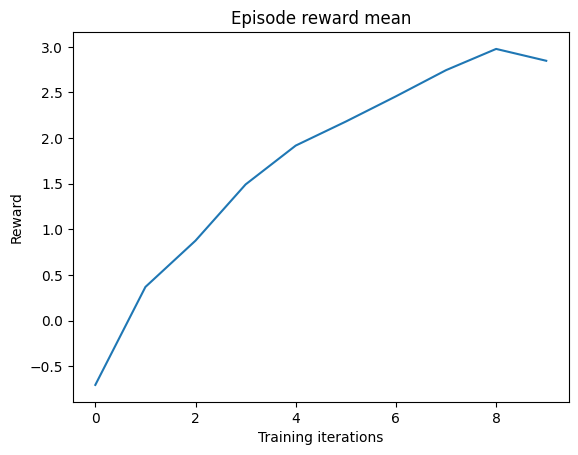

episode_reward_mean = 2.8473291397094727: 100%|██████████| 10/10 [11:37<00:00, 69.74s/it]


In [1]:
import torch
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal
from torchrl.objectives import ClipPPOLoss, ValueEstimators
from torch import multiprocessing
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from matplotlib import pyplot as plt
from tqdm import tqdm
import pyvirtualdisplay
from PIL import Image
from IPython.display import Image as IPImage


class VMASAgent:
    def __init__(self, scenario_name, vmas_device, num_agents=3, max_steps=100):
        self.scenario_name = scenario_name
        self.vmas_device = vmas_device
        self.num_agents = num_agents
        self.max_steps = max_steps

    def create_env(self):
        env = VmasEnv(
            scenario=self.scenario_name,
            num_envs=1,  # Corrected here, assuming you want to create a single environment
            continuous_actions=True,
            max_steps=self.max_steps,
            device=self.vmas_device,  # Use vmas_device here
            n_agents=self.num_agents,
        )
        env = TransformedEnv(
            env, RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")])
        )
        check_env_specs(env)
        return env


class Policy:
    def __init__(self, env, device):
        self.env = env
        self.device = device

    def create_policy(self):
        policy_net = torch.nn.Sequential(
            MultiAgentMLP(
                n_agent_inputs=self.env.observation_spec["agents", "observation"].shape[-1],
                n_agent_outputs=2 * self.env.action_spec.shape[-1],
                n_agents=self.env.n_agents,
                centralised=False,
                share_params=True,
                device=self.device,
                depth=2,
                num_cells=256,
                activation_class=torch.nn.Tanh,
            ),
            NormalParamExtractor(),
        )

        policy_module = TensorDictModule(
            policy_net,
            in_keys=[("agents", "observation")],
            out_keys=[("agents", "loc"), ("agents", "scale")],
        )

        policy = ProbabilisticActor(
            module=policy_module,
            spec=self.env.unbatched_action_spec,
            in_keys=[("agents", "loc"), ("agents", "scale")],
            out_keys=[self.env.action_key],
            distribution_class=TanhNormal,
            distribution_kwargs={
                "min": self.env.unbatched_action_spec[self.env.action_key].space.low,
                "max": self.env.unbatched_action_spec[self.env.action_key].space.high,
            },
            return_log_prob=True,
            log_prob_key=("agents", "sample_log_prob"),
        )

        return policy


class Critic:
    def __init__(self, env, device):
        self.env = env
        self.device = device

    def create_critic(self):
        critic_net = MultiAgentMLP(
            n_agent_inputs=self.env.observation_spec["agents", "observation"].shape[-1],
            n_agent_outputs=1,
            n_agents=self.env.n_agents,
            centralised=True,
            share_params=True,
            device=self.device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        )

        critic = TensorDictModule(
            module=critic_net,
            in_keys=[("agents", "observation")],
            out_keys=[("agents", "state_value")],
        )

        return critic


class Trainer:
    def __init__(
        self,
        env,
        policy,
        critic,
        device,
        frames_per_batch=6000,
        n_iters=10,
        num_epochs=30,
        minibatch_size=400,
        lr=3e-4,
        max_grad_norm=1.0,
        clip_epsilon=0.2,
        gamma=0.9,
        lmbda=0.9,
        entropy_eps=1e-4,
    ):
        self.env = env
        self.policy = policy
        self.critic = critic
        self.device = device
        self.frames_per_batch = frames_per_batch
        self.n_iters = n_iters
        self.num_epochs = num_epochs
        self.minibatch_size = minibatch_size
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.clip_epsilon = clip_epsilon
        self.gamma = gamma
        self.lmbda = lmbda
        self.entropy_eps = entropy_eps

    def train(self):
        collector = SyncDataCollector(
            self.env,
            self.policy,
            device=self.device,
            storing_device=self.device,
            frames_per_batch=self.frames_per_batch,
            total_frames=self.frames_per_batch * self.n_iters,
        )

        replay_buffer = ReplayBuffer(
            storage=LazyTensorStorage(self.frames_per_batch, device=self.device),
            sampler=SamplerWithoutReplacement(),
            batch_size=self.minibatch_size,
        )

        loss_module = ClipPPOLoss(
            actor_network=self.policy,
            critic_network=self.critic,
            clip_epsilon=self.clip_epsilon,
            entropy_coef=self.entropy_eps,
            normalize_advantage=False,
        )
        loss_module.set_keys(
            reward=self.env.reward_key,
            action=self.env.action_key,
            sample_log_prob=("agents", "sample_log_prob"),
            value=("agents", "state_value"),
            done=("agents", "done"),
            terminated=("agents", "terminated"),
        )

        loss_module.make_value_estimator(ValueEstimators.GAE, gamma=self.gamma, lmbda=self.lmbda)

        GAE = loss_module.value_estimator

        optim = torch.optim.Adam(loss_module.parameters(), lr=self.lr)

        pbar = tqdm(total=self.n_iters, desc="episode_reward_mean = 0")

        episode_reward_mean_list = []
        for _ in range(self.n_iters):
            for tensordict_data in collector:
                tensordict_data.set(
                    ("next", "agents", "done"),
                    tensordict_data.get(("next", "done"))
                    .unsqueeze(-1)
                    .expand(tensordict_data.get_item_shape(("next", self.env.reward_key))),
                )

                tensordict_data.set(
                    ("next", "agents", "terminated"),
                    tensordict_data.get(("next", "terminated"))
                    .unsqueeze(-1)
                    .expand(tensordict_data.get_item_shape(("next", self.env.reward_key))),
                )

                with torch.no_grad():
                    GAE(
                        tensordict_data,
                        params=loss_module.critic_network_params,
                        target_params=loss_module.target_critic_network_params,
                    )

                data_view = tensordict_data.reshape(-1)
                replay_buffer.extend(data_view)

                for _ in range(self.num_epochs):
                    for _ in range(self.frames_per_batch // self.minibatch_size):
                        subdata = replay_buffer.sample()
                        loss_vals = loss_module(subdata)

                        loss_value = (
                            loss_vals["loss_objective"]
                            + loss_vals["loss_critic"]
                            + loss_vals["loss_entropy"]
                        )

                        loss_value.backward()

                        torch.nn.utils.clip_grad_norm_(
                            loss_module.parameters(), self.max_grad_norm
                        )

                        optim.step()
                        optim.zero_grad()

                collector.update_policy_weights_()

                done = tensordict_data.get(("next", "agents", "done"))
                episode_reward_mean = (
                    tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
                )
                episode_reward_mean_list.append(episode_reward_mean)
                pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
                pbar.update()

        plt.plot(episode_reward_mean_list)
        plt.xlabel("Training iterations")
        plt.ylabel("Reward")
        plt.title("Episode reward mean")
        plt.show()


class ImageGenerator:
    def __init__(self, env, max_steps, policy):
        self.env = env
        self.max_steps = max_steps
        self.policy = policy

    def generate_gif(self, filename):
        def rendering_callback(env, td):
            env.frames.append(Image.fromarray(env.render(mode="rgb_array")))

        self.env.frames = []
        with torch.no_grad():
            self.env.rollout(
                max_steps=self.max_steps,
                policy=self.policy,
                callback=rendering_callback,
                auto_cast_to_device=True,
                break_when_any_done=False,
            )
        self.env.frames[0].save(
            filename, save_all=True, append_images=self.env.frames[1:], duration=3, loop=0
        )


if __name__ == "__main__":
    # Determine if multiprocessing is using forking
    is_fork = multiprocessing.get_start_method() == "fork"

    # Determine the device
    vmas_device = torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device("cpu")

    # Define other variables
    scenario_name = "navigation"
    num_agents = 3
    max_steps = 100

    # Create VMASAgent instance
    vmas_agent = VMASAgent(scenario_name, vmas_device, num_agents=num_agents, max_steps=max_steps)

    # Create environment
    env = vmas_agent.create_env()

    # Create policy
    policy_creator = Policy(env, vmas_device)
    policy = policy_creator.create_policy()

    # Create critic
    critic_creator = Critic(env, vmas_device)
    critic = critic_creator.create_critic()

    # Create trainer and train
    trainer = Trainer(env, policy, critic, vmas_device)
    trainer.train()

    # Generate and display GIF
    img_gen = ImageGenerator(env, max_steps, policy)
    img_gen.generate_gif(f"{scenario_name}.gif")

    IPImage(open(f"{scenario_name}.gif", "rb").read())
